# Traffic Signs Classification
### Test model

In this model, I'll take one of the models generated to classify traffic signs, run in against the test dataset and plot the results.

In [1]:
import os
import cv2
import csv
import glob
import pickle
import random
import numpy as np
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt

from models.cnn_models import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

Using TensorFlow backend.


In [2]:
# Data path
data_path = 'data/custom/'

# Pickle file
test_pickle_file = 'test.p'

# Classes file
classes_file = 'classes.csv'

In [3]:
# Load classes
with open(os.path.join(data_path, classes_file), mode='r') as csv_file:
    reader = csv.reader(csv_file)
    classes = {rows[0]:rows[1] for rows in reader}

In [4]:
# Load test data
test_file = open(os.path.join(data_path, test_pickle_file), 'rb')
test_data = pickle.load(test_file)

In [5]:
# Data shape
print('x_test data shape:', test_data['features'].shape)
print('y_test data shape:', test_data['labels'].shape)

x_test data shape: (4620, 64, 64, 3)
y_test data shape: (4620,)


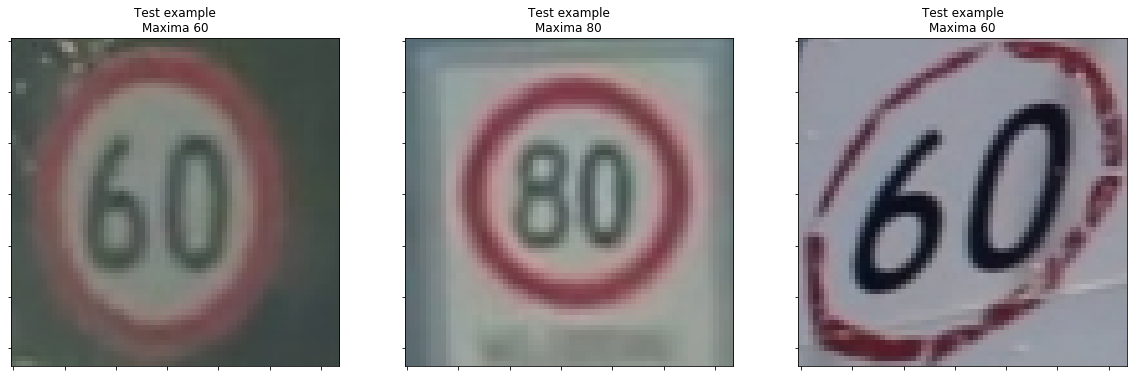

In [6]:
# Verify data
fig = plt.figure()

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

index = random.randrange(0, len(test_data['features']))
ax1.imshow(test_data['features'][index])
ax1.set_title('Test example\n' + classes[str(test_data['labels'][index])])
ax1.set_yticklabels([])
ax1.set_xticklabels([])

index = random.randrange(0, len(test_data['features']))
ax2.imshow(test_data['features'][index])
ax2.set_title('Test example\n' + classes[str(test_data['labels'][index])])
ax2.set_yticklabels([])
ax2.set_xticklabels([])

index = random.randrange(0, len(test_data['features']))
ax3.imshow(test_data['features'][index])
ax3.set_title('Test example\n' + classes[str(test_data['labels'][index])])
ax3.set_yticklabels([])
ax3.set_xticklabels([])

plt.show()

In [7]:
# Organize testing data
x_test = test_data['features']
y_test = test_data['labels']

In [8]:
# Make RGB values between 0 and 1
x_test = x_test.astype('float32')
x_test /= 255

In [9]:
# Convert labels to one hot encoding
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

# Load model and weights

In [10]:
# Checkpoint path
checkpoint_path = 'checkpoints/'

# Model name
model_name = 'model_4_custom'

# Model function
model_function = model_4

# Weights path
weights_name = 'model_4_custom-weights-10-1.00.hdf5'
weights_path = os.path.join(os.path.join(checkpoint_path, model_name), weights_name)

In [11]:
model = model_function(weights_path)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 66, 66, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 66, 66, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 34, 34, 64)        0         
__________

In [12]:
# Compile model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [13]:
# Evaluate model
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0995466307971
Test accuracy: 0.975974025974


## Evaluate model against latest checkpoints
Here, I'll try to find the best weights to use by evaluating the model with each weights against the test data.

In [ ]:
file_filter = '*.hdf5'
folder = os.path.join(checkpoint_path, model_name)
weights_files = sorted(glob.glob(os.path.join(folder, file_filter)))

data = {}

In [ ]:
for weight_file in tqdm_notebook(weights_files):
    # Load weights
    model = model_function(weight_file)

    # Compile model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

    # Evaluate model
    score = model.evaluate(x_test, y_test, verbose=0)

    data[weight_file] = {'test_loss': score[0], 'test_acc': score[1]}

In [ ]:
max_acc = 0
max_acc_weights = None

for key in data.keys():
    if data[key]['test_acc'] > max_acc:
        max_acc = data[key]['test_acc']
        max_acc_weights = key
        
print('Max. accuracy:', max_acc)
print('Max. accuracy weights:', max_acc_weights)

In [14]:
max_acc_weights = 'checkpoints/model_3_custom/model_3_custom-weights-18-1.00.hdf5'

### Evaluate against 'best' weights

In [15]:
# Load weights
model = model_function(max_acc_weights)

# Compile model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [16]:
# Evaluate model
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss: {0:.6f}'.format(score[0]))
print('Test accuracy: {0:.2f}%'.format(score[1]*100))

Test loss: 0.122737
Test accuracy: 97.49%


### Top-k accuracy

In [14]:
def top_K_acc(y_true, y_pred, k):
    assert y_true.shape == y_pred.shape
    top_k_indx = np.argsort(y_pred, axis=1)[:,:-(k+1):-1]
    n_guessed = 0
    for i in range(len(y_true)):
        n_guessed += np.any(y_true[i,top_k_indx[i]])
    
    acc = n_guessed / len(y_true)
    
    return acc

In [15]:
y_pred = model.predict(x_test)

for k in range(1, 6):
    acc = top_K_acc(y_test, y_pred, k)
    print('Top-' + str(k), 'accuracy:', '{0:.2f}%'.format(acc*100))

Top-1 accuracy: 97.60%
Top-2 accuracy: 99.18%
Top-3 accuracy: 99.48%
Top-4 accuracy: 99.81%
Top-5 accuracy: 99.91%


### Time single forward pass

In [16]:
import time

image_path = '/home/arian/asdf.png'

start_time = time.time()
img = cv2.imread(image_path)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img = img[...,::-1]
img = np.expand_dims(img, axis=0)
end_time = time.time()
image_load_time = end_time - start_time
print('Image preprocessing took {0:.3f} seconds'.format(image_load_time))

start_time = time.time()
predicted_class = model.predict_classes(img, verbose=False)
end_time = time.time()
prediction_time = end_time - start_time

print('Prediction took {0:.3f} seconds'.format(prediction_time))

Image preprocessing took 0.063 seconds
Prediction took 0.104 seconds


In [17]:
print(classes[str(predicted_class[0])])

Maxima 60


In [18]:
probs = model.predict(img, verbose=False)
for prob in probs[0]:
    print(prob, '\n')

0.0 

0.0 

0.0 

0.0 

0.0 

0.0 

0.0 

1.0 

0.0 



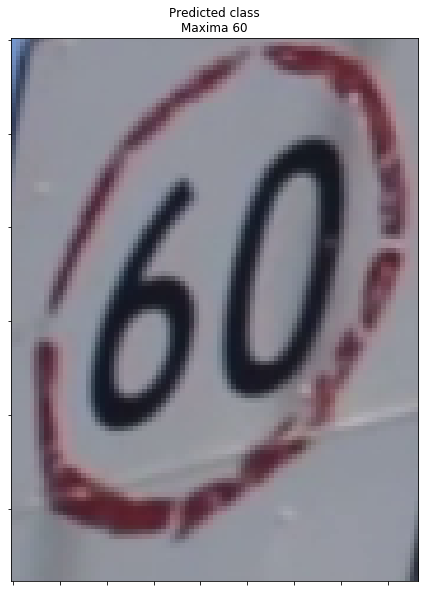

In [19]:
img = cv2.imread(image_path)
img = img[...,::-1]
plt.imshow(img)

plt.axes().set_title('Predicted class\n' + classes[str(predicted_class[0])])
plt.axes().set_yticklabels([])
plt.axes().set_xticklabels([])
plt.show()

### Wrong classified images

In [35]:
# Get indexes of images incorrectly classified
predicted_classes = model.predict_classes(x_test, verbose=False)
predicted_classes_categorical = keras.utils.to_categorical(predicted_classes, NUM_CLASSES)
wrong_indexes = np.unique(np.where(predicted_classes_categorical != y_test)[0])

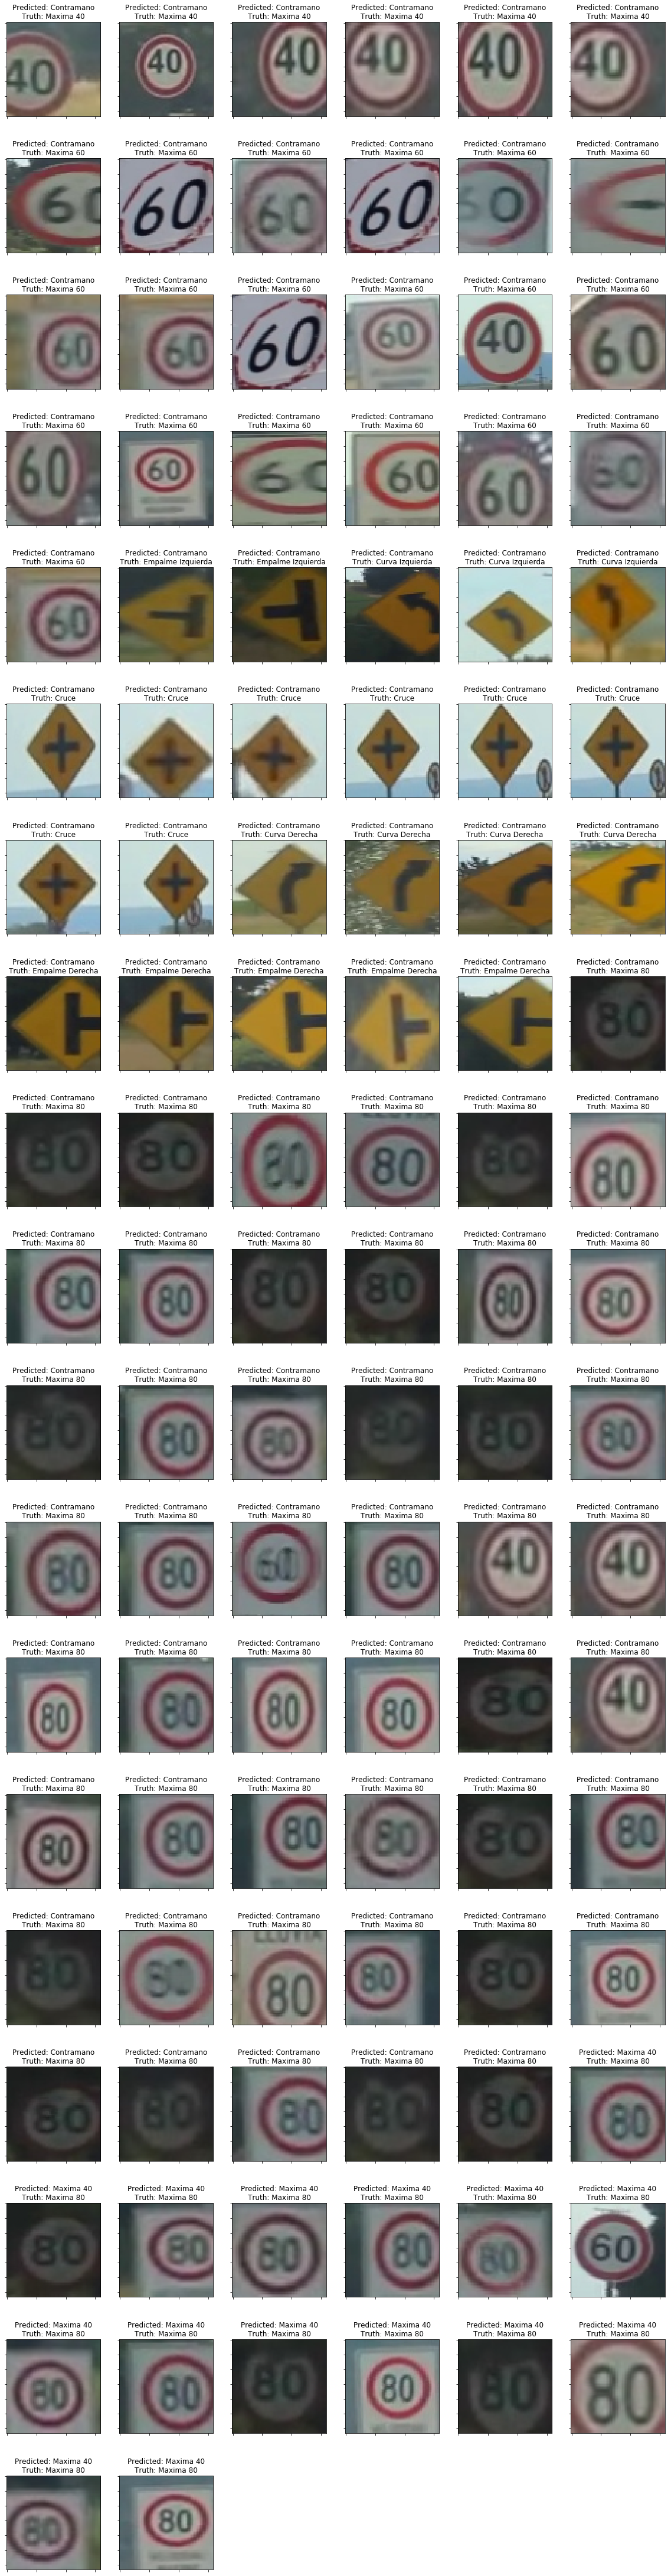

In [60]:
# Plot all incorrectly classified images with truth and predicted label
import math

plt.rcParams['figure.figsize'] = (20, 80)
fig = plt.figure()

rows = 6
cols = math.ceil((len(wrong_indexes) / rows))

for index in range(len(wrong_indexes) - 1):
    ax = fig.add_subplot(cols, rows, index + 1)
        
    ax.imshow(x_test[wrong_indexes[index]])
    
    predicted_class = predicted_classes[index]
    # print('Predicted {}: {}'.format(predicted_class,))

    truth_class = np.where(y_test[wrong_indexes[index]] == 1)[0][0]
    # print('Truth {}: {}'.format(truth_class, classes[str(truth_class)]))
    
    ax.set_title('Predicted: ' +  classes[str(predicted_class)] + '\nTruth: ' +  classes[str(truth_class)])
    ax.set_yticklabels([])
    ax.set_xticklabels([])

plt.show()

In [ ]:
wrong_indexes[0]

In [ ]:
test = x_test[wrong_indexes[0]]
plt.imshow(test)
plt.show()

In [ ]:
predicted = model.predict_classes(np.expand_dims(test, axis=0), verbose=False)

In [ ]:
predicted_class = predicted[0]
print('Predicted {}: {}'.format(predicted_class, classes[str(predicted_class)]))

truth_class = np.where(y_test[wrong_indexes[0]] == 1)[0][0]
print('Truth {}: {}'.format(truth_class, classes[str(truth_class)]))

In [ ]:
predited_prob = model.predict_proba(np.expand_dims(x_test[0], axis=0))

In [ ]:
predited_prob

In [ ]:
np.argmax(predited_prob)

In [ ]:
img = cv2.imread('/home/arian/2.png')
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img = np.expand_dims(img, axis=0)
probs = model.predict_proba(img, verbose=False)

for prob in probs[0]:
    print('{0:.3f}'.format(prob))
    
print(np.argmax(probs))

# Test image with sigmoid

In [49]:
image_path = '/home/arian/1.png'

img = cv2.imread(image_path)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img = img[...,::-1]
img = np.expand_dims(img, axis=0)

predictions = model.predict(img, verbose=False)[0]
class_id = np.argmax(predictions)

threshold = 0.5

if predictions[class_id] > threshold:
    print('Predictions:')
    print('\tClass ID:', class_id)
    print('\tClass Label:', classes[str(class_id)])
    print('\tProbability:', predictions[class_id])
else:
    print('No predictions')

No predictions
